# **Data Preprocessing**
# No need to run again

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn import svm
import pandas as pd
from sklearn import metrics
%matplotlib inline
import cv2
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/HateSpeech
!pwd

/content/gdrive/MyDrive/HateSpeech
/content/gdrive/MyDrive/HateSpeech


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("Ethos_Dataset_Multi_Label.csv", delimiter=';')

# Define function to assign single label per comment
def map_to_label(row):
    if row['violence'] > 0.7 or row['directed_vs_generalized'] > 0.7:
        return 'toxic'
    elif row[['race', 'religion', 'national_origin']].max() > 0.7:
        return 'hateful'
    elif row[['gender', 'sexual_orientation', 'disability']].max() > 0.7:
        return 'abusive'
    elif row.drop('comment').max() <= 0.3:
        return 'non-toxic'
    else:
        return 'moderate'

# Apply mapping
df['label'] = df.apply(map_to_label, axis=1)

# Keep only the needed columns
df_clean = df[['comment', 'label']]

# Save to new file
df_clean.to_csv("ethos_single_label.csv", index=False)

In [ ]:
pip install transformers pandas scikit-learn torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd

# Load your preprocessed single-label data
df = pd.read_csv("ethos_single_label.csv")

# Preview labels
print(df['label'].value_counts())

label
toxic       166
hateful     104
abusive     101
moderate     62
Name: count, dtype: int64


# Model Training

In [ ]:
import pandas as pd, numpy as np, tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, models

df = pd.read_csv('/content/HateSpeech Single Label.csv')
df.head()

In [ ]:
print(df['label'].value_counts())
print("Rows :", len(df))

label
toxic       166
hateful     104
abusive     101
moderate     62
Name: count, dtype: int64
Rows : 433


In [ ]:
label_to_id = {l:i for i,l in enumerate(sorted(df['label'].unique()))}
id_to_label = {i:l for l,i in label_to_id.items()}
df['label_id'] = df['label'].map(label_to_id)

num_classes = len(label_to_id)

In [ ]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_id']
)

In [ ]:
max_tokens  = 20_000      # vocab cap
max_length  = 100          # truncate / pad length

vectoriser = TextVectorization(
    max_tokens     = max_tokens,
    output_mode    = 'int',
    output_sequence_length = max_length,
    standardize    = 'lower_and_strip_punctuation',
    split          = 'whitespace'
)

# Build the vocabulary from the training text only
vectoriser.adapt(train_df['comment'].values)

In [ ]:
embedding_dim = 64

inputs  = layers.Input(shape=(1,), dtype=tf.string)
x = vectoriser(inputs)
x = layers.Embedding(max_tokens, embedding_dim)(x)
x = layers.Bidirectional(layers.LSTM(12))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 100, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 24)             │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,287,492 (4.91 MB)

 Trainable params: 1,287,492 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 8

def make_ds(dataframe, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (dataframe['comment'].values,
         dataframe['label_id'].values)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), seed=42)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, shuffle=True)
val_ds   = make_ds(val_df)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = 25,
    callbacks       = callbacks
)

In [ ]:
model.save('/content/hate_speech_lstm.keras')

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.3f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5169 - loss: 1.2117
Validation accuracy: 0.483


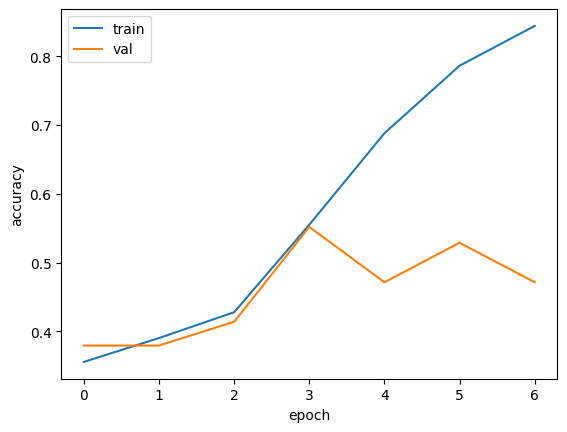

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('accuracy');

In [ ]:
# loaded = tf.keras.models.load_model('/content/hate_speech_lstm.keras')
# sample  = ["You are an absolute disgrace."]
# pred    = loaded.predict(sample)
# label   = id_to_label[int(pred.argmax(1))]
# print(label)

# Model Training Bert


In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/HateSpeech/ethos_single_label.csv')
print(df.head())
print(df['label'].value_counts())
print("Rows:", len(df))

In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install torch

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

In [ ]:
df.dropna(subset=['label'], inplace=True)


label_map = {'toxic': 0, 'hateful': 1, 'abusive': 2, 'moderate': 3}
df['label'] = df['label'].map(label_map)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Apply tokenization
inputs = tokenize_data(df['comment'].tolist(), tokenizer)

# Prepare labels as tensor
labels = torch.tensor(df['label'].values)

# Split data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs['input_ids'], labels, test_size=0.2)

# Convert data into DataLoader format
train_data = TensorDataset(train_inputs, train_labels)
val_data = TensorDataset(val_inputs, val_labels)

train_dataloader = DataLoader(train_data, batch_size=16)
val_dataloader = DataLoader(val_data, batch_size=16)

# Initialize BERT for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop (simplified)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):
    model.train()
    for batch in train_dataloader:
        batch_input_ids, batch_labels = [b.to(device) for b in batch]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_input_ids, labels=batch_labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} complete.")

# Validation loop (evaluating model performance)
model.eval()
val_loss = 0
val_correct = 0
val_total = 0

with torch.no_grad():
    for batch in val_dataloader:
        batch_input_ids, batch_labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(batch_input_ids, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Calculate loss and accuracy
        val_loss += loss.item()

        # Get predictions
        predictions = torch.argmax(logits, dim=1)

        # Count correct predictions
        val_correct += (predictions == batch_labels).sum().item()
        val_total += batch_labels.size(0)

val_loss /= len(val_dataloader)
val_accuracy = val_correct / val_total

print(f"Validation loss: {val_loss:.3f}")
print(f"Validation accuracy: {val_accuracy:.3f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1 complete.


In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.3f}")